In [13]:
import pandas as pd

# Always reload the data to avoid stale state
df = pd.read_csv("../data/clean/merged_df_clean.csv") 

# Clean and prep
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values(by=['visit_id', 'date_time'])

# Calculate stepuration by visit
df['step_duration'] = df.groupby('visit_id')['date_time'].diff()
df = df.dropna(subset=['step_duration'])
df['step_duration_seconds'] = df['step_duration'].dt.total_seconds()

# Group by Variation and process_step
avg_duration_by_visit = df.groupby(['Variation', 'process_step'])['step_duration_seconds'].mean().reset_index()

# Pivot and order steps
pivot_by_visit = avg_duration_by_visit.pivot(index='process_step', columns='Variation', values='step_duration_seconds')
ordered_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
pivot_by_visit = pivot_by_visit.reindex(ordered_steps)

# Display
pivot_by_visit


Variation,Control,Test
process_step,,
start,153.805258,148.358859
step_1,43.003881,37.685521
step_2,38.673796,48.135489
step_3,92.954099,96.851483
confirm,128.646669,128.889366


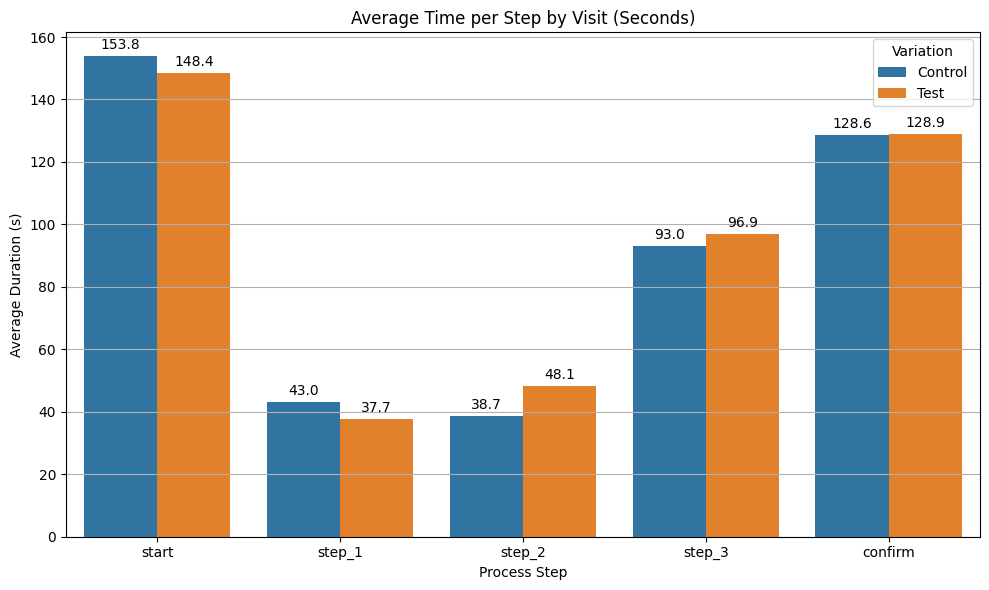

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 1: Load clean data fresh
df = pd.read_csv("../data/clean/merged_df_clean.csv") 
df['date_time'] = pd.to_datetime(df['date_time'])

# STEP 2: Sort and compute step durations cleanly
df = df.sort_values(by=['visit_id', 'date_time'])
df['step_duration'] = df.groupby('visit_id')['date_time'].diff()
df = df.dropna(subset=['step_duration'])
df['step_duration_seconds'] = df['step_duration'].dt.total_seconds()

# STEP 3: Group by variation and process step
avg_duration_by_visit = df.groupby(['Variation', 'process_step'])['step_duration_seconds'].mean().reset_index()

# STEP 4: Enforce step order and sort
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
avg_duration_by_visit['process_step'] = pd.Categorical(avg_duration_by_visit['process_step'], categories=step_order, ordered=True)
avg_duration_by_visit = avg_duration_by_visit.sort_values(by='process_step')

# STEP 5: Bar chart with value labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=avg_duration_by_visit, x='process_step', y='step_duration_seconds', hue='Variation')
plt.title('Average Time per Step by Visit (Seconds)')
plt.ylabel('Average Duration (s)')
plt.xlabel('Process Step')
plt.grid(axis='y')
plt.tight_layout()

# Add seconds on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', padding=3)

plt.legend(title='Variation')
plt.show()


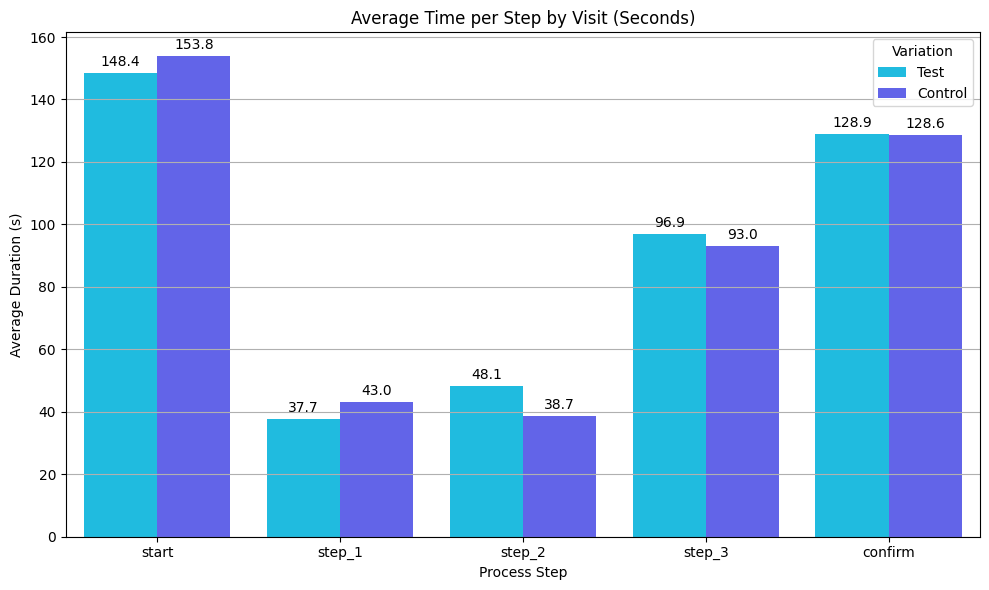

In [17]:
# Re-import required libraries and reload clean data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("../data/clean/merged_df_clean.csv") 
df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values(by=['visit_id', 'date_time'])

# Calculate step durations
df['step_duration'] = df.groupby('visit_id')['date_time'].diff()
df = df.dropna(subset=['step_duration'])
df['step_duration_seconds'] = df['step_duration'].dt.total_seconds()

# Group by Variation and step
avg_duration_by_visit = df.groupby(['Variation', 'process_step'])['step_duration_seconds'].mean().reset_index()

# Enforce correct step order
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
avg_duration_by_visit['process_step'] = pd.Categorical(avg_duration_by_visit['process_step'], categories=step_order, ordered=True)
avg_duration_by_visit = avg_duration_by_visit.sort_values(by='process_step')

# Set colors to match screenshot: Test = light blue, Control = purple
color_palette = {"Test": "#00CFFF", "Control": "#4B4EFF"}  # approximated from screenshot

# Plot bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=avg_duration_by_visit,
    x='process_step',
    y='step_duration_seconds',
    hue='Variation',
    hue_order=['Test', 'Control'],
    palette=color_palette
)

plt.title('Average Time per Step by Visit (Seconds)')
plt.ylabel('Average Duration (s)')
plt.xlabel('Process Step')
plt.tight_layout()
plt.grid(axis='y')

# Add seconds on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', label_type='edge', padding=3)

plt.legend(title='Variation')
plt.show()


/var/folders/74/2xg39v_50tv7vj24jw0r0b800000gn/T/ipykernel_62506/929831493.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  step_by_age = df.groupby(['age_group', 'Variation', 'process_step'])['step_duration_seconds'].mean().reset_index()
/var/folders/74/2xg39v_50tv7vj24jw0r0b800000gn/T/ipykernel_62506/929831493.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_steps = step_by_age.pivot_table(index=['age_group', 'process_step'], columns='Variation', values='step_duration_seconds')


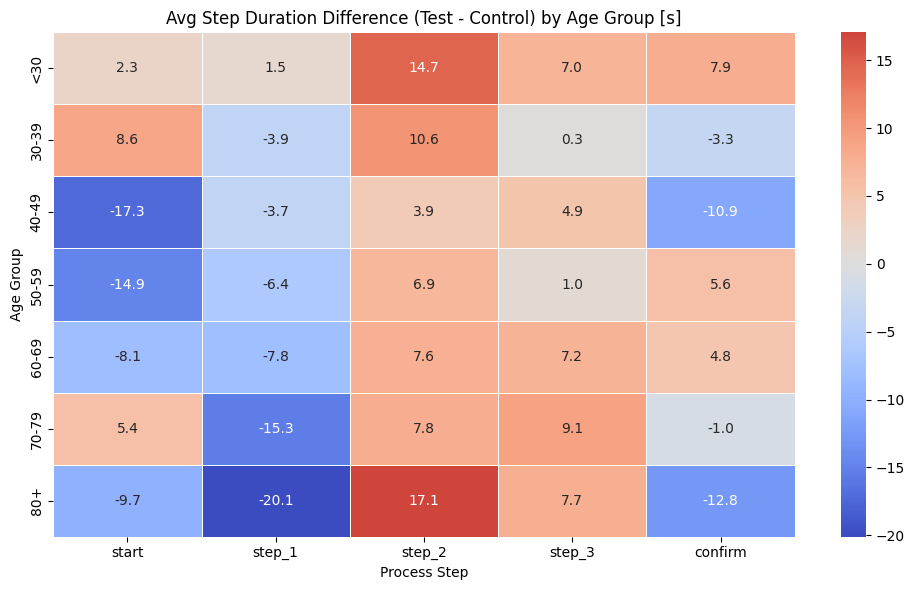

In [19]:
# Create age groups
bins = [0, 29, 39, 49, 59, 69, 79, 150]
labels = ['<30', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
df['age_group'] = pd.cut(df['clnt_age'], bins=bins, labels=labels, right=True)


# Group by age group, variation, and process step to compute average step duration
step_by_age = df.groupby(['age_group', 'Variation', 'process_step'])['step_duration_seconds'].mean().reset_index()

# Pivot to get Test and Control side-by-side
pivot_steps = step_by_age.pivot_table(index=['age_group', 'process_step'], columns='Variation', values='step_duration_seconds')

# Calculate difference between Test and Control
pivot_steps['Difference'] = pivot_steps['Test'] - pivot_steps['Control']

# Reshape for heatmap: steps as columns, age groups as rows
heatmap_data = pivot_steps['Difference'].unstack().reindex(columns=['start', 'step_1', 'step_2', 'step_3', 'confirm'])

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Avg Step Duration Difference (Test - Control) by Age Group [s]")
plt.xlabel("Process Step")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()


In [ ]:
This heatmap shows the difference in average time spent on each step of our website funnel between the Test and Control groups, segmented by age group.
We broke the user journey into 5 distinct steps:
start → step_1 → step_2 → step_3 → confirm

Each cell in the heatmap represents the difference in average step duration, measured in seconds, for a given age group.

A red cell means the Test group spent more time than Control at that step.
A blue cell indicates the Control group spent more time.

Large positive values (deep red) might suggest confusion introduced by the Test version.
Large negative values (deep blue) might suggest the Test version helped users complete that step faster.
Small values (light shades) mean the change was rather neutral.

In [20]:
# Group by age group, variation, and step
step_by_age = df.groupby(['age_group', 'Variation', 'process_step'])['step_duration_seconds'].mean().reset_index()

# Pivot to get Test and Control side-by-side
pivot_steps = step_by_age.pivot_table(index=['age_group', 'process_step'], columns='Variation', values='step_duration_seconds').reset_index()

# Add difference column
pivot_steps['difference_in_seconds'] = pivot_steps['Test'] - pivot_steps['Control']

# Save to CSV
pivot_steps.to_csv("age_step_diff_heatmap.csv", index=False)


/var/folders/74/2xg39v_50tv7vj24jw0r0b800000gn/T/ipykernel_62506/4066090249.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  step_by_age = df.groupby(['age_group', 'Variation', 'process_step'])['step_duration_seconds'].mean().reset_index()
/var/folders/74/2xg39v_50tv7vj24jw0r0b800000gn/T/ipykernel_62506/4066090249.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_steps = step_by_age.pivot_table(index=['age_group', 'process_step'], columns='Variation', values='step_duration_seconds').reset_index()
